# Set up env

In [1]:
import tensorflow as tf
from keras.datasets import mnist
import cv2
import os
import pathlib
from keras.layers import Conv2D, Conv2DTranspose, Dropout, Dense, Reshape, LayerNormalization, LeakyReLU
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score

# Loading the dataset

In [2]:
class ReadDataset:
    def __init__(self, datasetpath, labels, image_shape):
        self.datasetpath = datasetpath
        self.labels = labels
        self.image_shape = image_shape
    def returListImages(self,):
        self.images = []
        for label in self.labels:
            self.images.append(list(pathlib.Path(os.path.join(self.datasetpath,
                                                              label)).glob('*.*')))
    def readImages(self,):
        self.returListImages()
        self.finalImages = []
        labels = []
        for label in range(len(self.labels)):
            for img in self.images[label]:
                img = cv2.imread(str(img))
                img = cv2.resize(img , self.image_shape)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img  = img/255
                self.finalImages.append(img)
                labels.append(label)
        images = np.array(self.finalImages)
        labels = np.array(labels)
        return images, labels

In [3]:
readDatasetObject = ReadDataset('chest-xray-pneumonia/chest_xray/train/',
                               ['NORMAL', 'PNEUMONIA'],
                               (224, 224))
images, labels = readDatasetObject.readImages()

In [4]:
images.shape, labels.shape

((5216, 224, 224, 3), (5216,))

The below will be useful in case you do not have enough memory while training the classifer.
Use them to save the nparray and load them again when needed. (Dont forget to del them after GAN training if you have low mem)

In [5]:
# np.save("imagesorg.npy",images)
# np.save("labelsorg.npy",labels)

In [3]:
# images=np.load("/kaggle/input/gans-224-224-pneumonia/imagesorg.npy")
# labels=np.load("/kaggle/input/gans-224-224-pneumonia/labelsorg.npy")

In [7]:
# images.shape, labels.shape

# GAN training

In [5]:
class Acgan:
    def __init__(self, eta, batch_size, epochs, weight_decay, latent_space,
                 image_shape, kernel_size):
        self.eta = eta
        self.batch_size = batch_size
        self.epochs = epochs
        self.weight_decay = weight_decay
        self.latent_space = latent_space
        self.image_shape = image_shape
        self.kernel_size = kernel_size

    def data(self, images, labels):
        ytrain = tf.keras.utils.to_categorical(labels)
        self.images = images
        self.labels = ytrain

    def samples(self, G, noize, labels):
        images = G.predict([noize, labels])
        ys = np.argmax(labels, axis=1)
        plt.figure(figsize=(12, 4))
        for i in range(16):
            plt.subplot(2, 8, (i + 1))
            plt.imshow(images[i], cmap='gray')
            plt.title(ys[i])
        plt.show()

    def generator(self, inputs, labels):
        filters = [256, 128, 64, 32]
        padding = 'same'
        x = inputs
        y = labels
        x = layers.concatenate([x, y])
        x = layers.Dense(1024)(x)
        x = layers.Dense(28* 28 * filters[0],
                         kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
        x = layers.Reshape((28, 28, filters[0]))(x)
        for filter in filters:
            if filter >= 64:
                strides = 2
            else:
                strides = 1
            x = LayerNormalization()(x)
            x = layers.Activation('relu')(x)
            x = Conv2DTranspose(filter, kernel_size=self.kernel_size, padding=padding,
                                strides=strides)(x)
        x = Conv2DTranspose(3, kernel_size=self.kernel_size, padding=padding)(x)
        x = layers.Activation('sigmoid')(x)
        self.generatorModel = models.Model(inputs=[inputs, labels],
                                           outputs=x,
                                           name='generator')

    def discriminator(self, inputs):
        x = inputs
        filters = [32, 64, 128, 256]
        padding = 'same'
        for filter in filters:
            if filter < 256:
                strides = 2
            else:
                strides = 1
            x = Conv2D(filter, kernel_size=self.kernel_size, padding=padding,
                       strides=strides,
                       kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
            x = LeakyReLU(alpha=0.2)(x)
        x = layers.Flatten()(x)
        outputs = Dense(1)(x)
        labelsOutput = Dense(256,
                             kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
        labelsOutput = Dropout(0.3)(labelsOutput)
        labelsOutput = Dense(2, )(labelsOutput)
        labelsOutput = layers.Activation('softmax')(labelsOutput)
        self.discriminatorModel = models.Model(inputs=inputs,
                                               outputs=[outputs, labelsOutput],
                                               name='discriminator')

    def build(self):
        generatorInput = layers.Input(shape=(self.latent_space))
        discriminatorInput = layers.Input(shape=(self.image_shape))
        labelsInput = layers.Input(shape=(2,))
        self.generator(generatorInput, labelsInput)
        self.discriminator(discriminatorInput)
        G = self.generatorModel
        D = self.discriminatorModel

        D.compile(loss=['mse', 'binary_crossentropy'],
                  optimizer=tf.keras.optimizers.RMSprop(learning_rate=self.eta,
                                                         weight_decay=self.weight_decay))
        D.summary()

        G.summary()
        D.trainable = False

        GAN = models.Model(inputs=[generatorInput, labelsInput],
                           outputs=D(G([generatorInput, labelsInput])))
        GAN.compile(loss=['mse', 'binary_crossentropy'],
                    optimizer=tf.keras.optimizers.RMSprop(learning_rate=self.eta * 0.5,
                                                           weight_decay=self.weight_decay * 0.5))
        GAN.summary()

        return G, D, GAN

    def trainAlgorithm(self, G, D, GAN):
        for epoch in range(self.epochs):
            indexs = np.random.randint(0, len(self.images), size=(self.batch_size,))
            realImages = self.images[indexs]
            realLabels = self.labels[indexs]
            realTag = tf.ones(shape=(self.batch_size,))
            noize = tf.random.uniform(shape=(self.batch_size,
                                             self.latent_space), minval=-1,
                                      maxval=1)
            fakeLabels = tf.keras.utils.to_categorical(np.random.choice(range(2), size=(self.batch_size)),
                                                       num_classes=2)
            fakeImages = tf.squeeze(G.predict([noize, fakeLabels], verbose=0))
            fakeTag = tf.zeros(shape=(self.batch_size,))
            allImages = np.vstack([realImages, fakeImages])
            allLabels = np.vstack([realLabels, fakeLabels])
            allTags = np.hstack([realTag, fakeTag])
            _, dlossTag, dlossLabels = D.train_on_batch(allImages, [allTags, allLabels])
            noize = tf.random.uniform(shape=(self.batch_size,
                                             self.latent_space), minval=-1,
                                      maxval=1)
            _, glossTag, glossLabels = GAN.train_on_batch([noize, fakeLabels], [realTag, fakeLabels])
            if epoch % 1000 == 0:
                print('Epoch: {}'.format(epoch))
                print('discriminator loss: [tag: {}, labels: {}], generator loss: [tag: {}, labels: {}]'.format(dlossTag,
                                                                                                                dlossLabels,
                                                                                                                glossTag,
                                                                                                                glossLabels))
                self.samples(G, noize, fakeLabels)


In [6]:
acgan = Acgan(eta = 0.0001, batch_size = 64, epochs = 15000, weight_decay = 6e-9,
              latent_space = 100, image_shape = (224,224, 3), kernel_size = 5)

In [7]:
acgan.data(images, labels)

In [8]:
G, D, GAN = acgan.build()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 32)         2432      ['input_2[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 112, 112, 32)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 56, 56, 64)           51264     ['leaky_re_lu[0][0]']         
                                                                                      

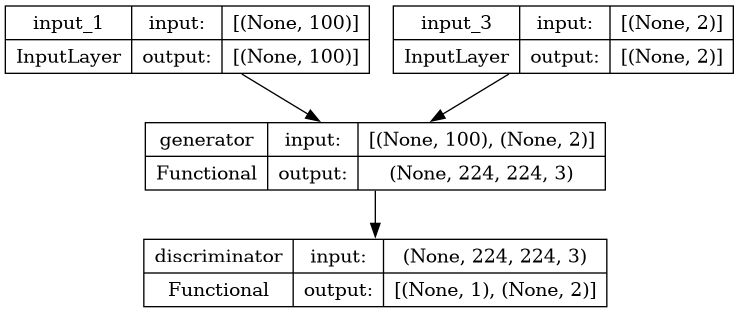

In [9]:
tf.keras.utils.plot_model(GAN, show_shapes = True)

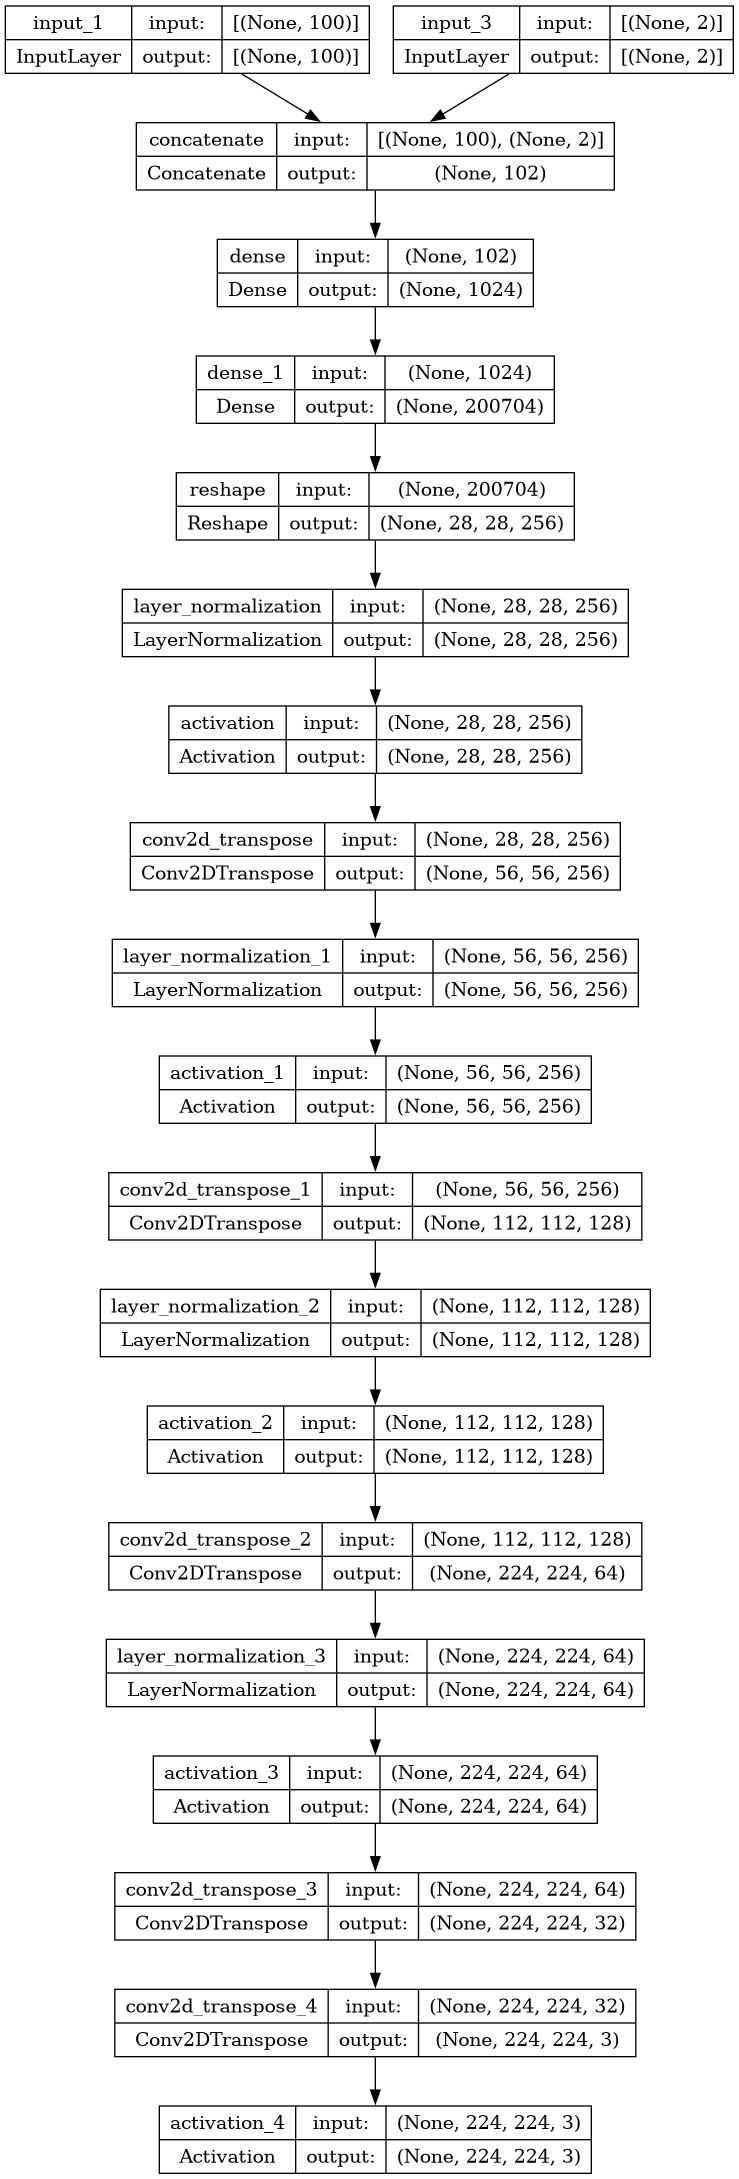

In [10]:
tf.keras.utils.plot_model(G, show_shapes = True)

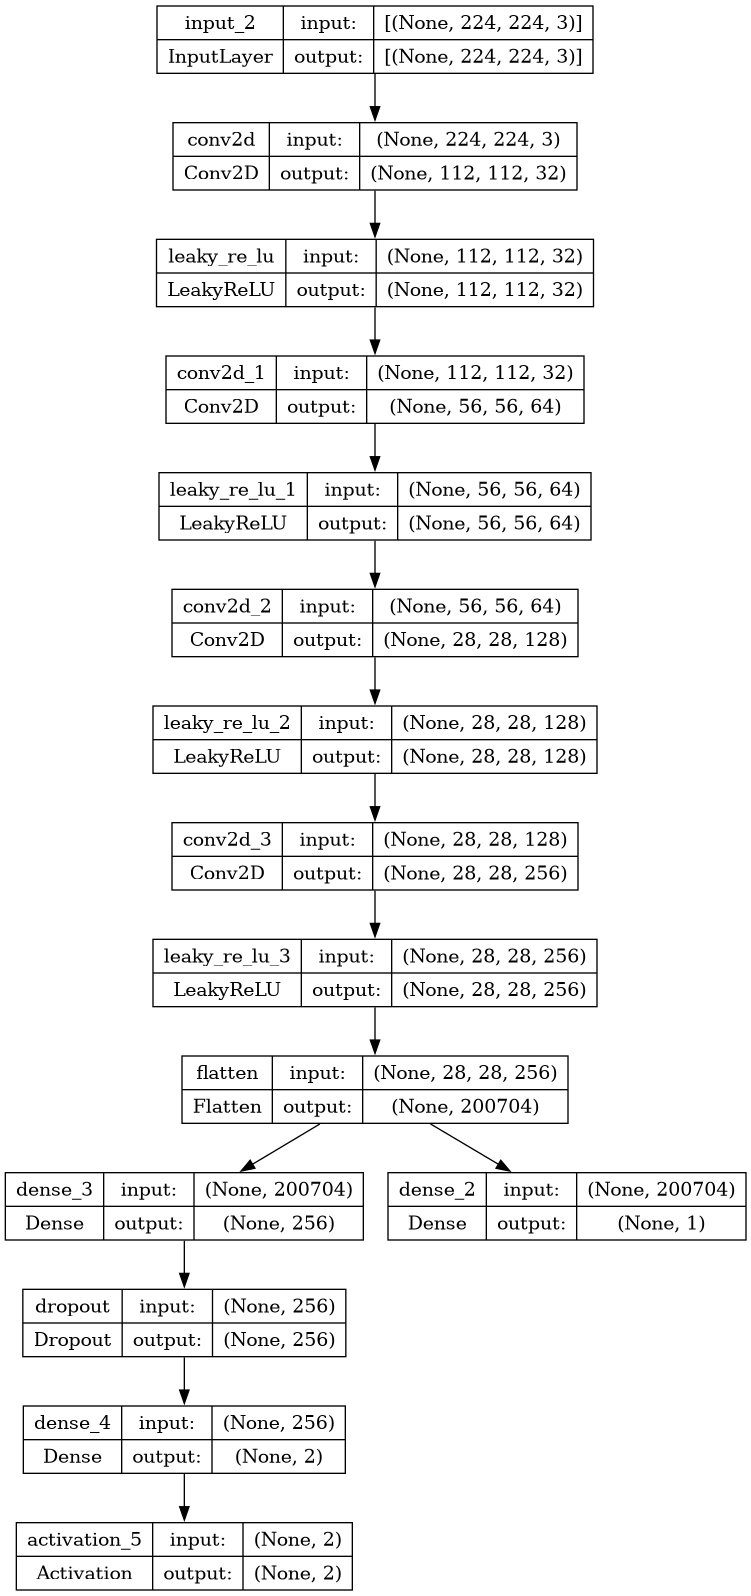

In [11]:
tf.keras.utils.plot_model(D, show_shapes = True)

In [15]:
acgan.trainAlgorithm(G, D, GAN)

In [16]:
G.save('generator_224*224_pneumonia.h5')

In [17]:
# G = tf.keras.models.load_model('generator_224*224_pneumonia.h5')

# Generating synthetic images

In [12]:
datasetGenerationSize = 10000
noize = tf.random.uniform(shape = (datasetGenerationSize, 100), minval = -1, maxval = 1)
newlabels = tf.keras.utils.to_categorical(np.random.choice([0, 1], size = (datasetGenerationSize, )), num_classes = 2)

In [13]:
noize.shape, newlabels.shape

(TensorShape([10000, 100]), (10000, 2))

In [14]:
np.unique(np.argmax(newlabels, axis = 1), return_counts = True)

(array([0, 1]), array([4962, 5038]))

In [ ]:
imagesGeneration = G.predict([noize, newlabels])
imagesGeneration.shape

In [ ]:
# np.save("GenImages.npy",imagesGeneration)
# np.save("labels.npy",newlabels)

In [18]:
# imagesGeneration=np.load("GenImages.npy")
# newlabels=np.load("labels.npy")

In [19]:
imagesGeneration.shape,newlabels.shape

((10000, 224, 224, 3), (10000, 2))

# Zipping the generated images according to their labels

In [ ]:
# import zipfile
# import os
# from PIL import Image


# output_folder = 'gen_images_pneumonia_224*224'
# os.makedirs(output_folder, exist_ok=True)

# # Create folders for each unique combination of labels
# unique_labels = set(map(tuple, newlabels))
# for label_pair in unique_labels:
#     label_folder = os.path.join(output_folder, f'label_{label_pair[0]}_{label_pair[1]}')
#     os.makedirs(label_folder, exist_ok=True)

# for i, (generated_image, label_pair) in enumerate(zip(imagesGeneration, newlabels)):
#     img = Image.fromarray((generated_image * 255).astype('uint8'))  # Convert to PIL Image
#     label_folder = os.path.join(output_folder, f'label_{label_pair[0]}_{label_pair[1]}')
#     img_filename = os.path.join(label_folder, f'gen_image_pneumonia_224*224_{i}.png')
#     img.save(img_filename)

# # Create a zip file containing all the generated images
# zip_filename = 'gen_images_pneumonia_224*224.zip'
# with zipfile.ZipFile(zip_filename, 'w') as zip_file:
#     for root, dirs, files in os.walk(output_folder):
#         for file in files:
#             file_path = os.path.join(root, file)
#             arcname = os.path.relpath(file_path, output_folder)
#             zip_file.write(file_path, arcname=arcname)

# # Optional: Remove the individual image files if you don't need them anymore
# for root, dirs, files in os.walk(output_folder):
#     for file in files:
#         file_path = os.path.join(root, file)
#         os.remove(file_path)

# # Optional: Remove the output folder
# for label_pair in unique_labels:
#     os.rmdir(os.path.join(output_folder, f'label_{label_pair[0]}_{label_pair[1]}'))
# os.rmdir(output_folder)


Use this to remove the GAN model from GPU mem to free VRAM

In [ ]:
# del G
# del D
# del GAN

# Defining the classifier architecture

In [20]:
basemodel = tf.keras.applications.VGG16(weights = None, input_shape = (224, 224, 3),
                                        pooling = 'max', include_top = False)
x = layers.Dropout(0.4)(basemodel.output)
x = layers.Dense(128,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(32,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)
m = tf.keras.models.Model(inputs = basemodel.input, outputs = x)
m.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001),metrics=["accuracy"])
m.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Training the classifier

In [21]:
history = m.fit(imagesGeneration, np.argmax(newlabels, axis = 1),
                epochs = 60, batch_size = 64,
                validation_split = 0.2,
                callbacks = [tf.keras.callbacks.EarlyStopping(patience = 4, monitor = 'val_loss', mode = 'min',
                                                              restore_best_weights = True)])

Epoch 1/60
125/125 [==============================] - 73s 451ms/step - loss: 0.5655 - accuracy: 0.7078 - val_loss: 0.6865 - val_accuracy: 0.8050
Epoch 2/60
125/125 [==============================] - 52s 415ms/step - loss: 0.2091 - accuracy: 0.9574 - val_loss: 0.6609 - val_accuracy: 0.9950
Epoch 3/60
125/125 [==============================] - 52s 415ms/step - loss: 0.1229 - accuracy: 0.9941 - val_loss: 0.5727 - val_accuracy: 0.9970
Epoch 4/60
125/125 [==============================] - 52s 415ms/step - loss: 0.0945 - accuracy: 0.9984 - val_loss: 0.3643 - val_accuracy: 0.9965
Epoch 5/60
125/125 [==============================] - 52s 415ms/step - loss: 0.0810 - accuracy: 0.9991 - val_loss: 0.1691 - val_accuracy: 0.9975
Epoch 6/60
125/125 [==============================] - 52s 415ms/step - loss: 0.0773 - accuracy: 0.9995 - val_loss: 0.0733 - val_accuracy: 0.9985
Epoch 7/60
125/125 [==============================] - 52s 415ms/step - loss: 0.0689 - accuracy: 0.9994 - val_loss: 0.0546 - val_ac

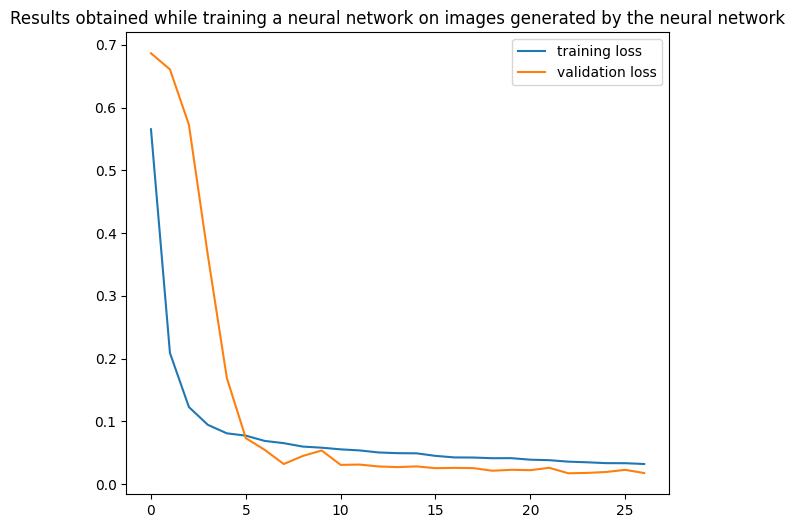

In [22]:
plt.figure(figsize = (7, 6))
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title('Results obtained while training a neural network on images generated by the neural network')
plt.legend()

In [27]:
m.evaluate(images, labels)

163/163 [==============================] - 13s 67ms/step - loss: 0.2368 - accuracy: 0.9436


[0.23676398396492004, 0.9436349868774414]

In [28]:
y_pred = tf.squeeze(m.predict(images))
y_pred.shape

163/163 [==============================] - 11s 64ms/step


TensorShape([5216])

In [29]:
y_pred = y_pred >= 0.5
y_pred = np.array(y_pred, dtype = 'int32')

In [30]:
accuracy_score(y_pred, labels)*100

94.36349693251533

In [31]:
print(classification_report(y_pred, labels))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1449
           1       0.95      0.98      0.96      3767

    accuracy                           0.94      5216
   macro avg       0.94      0.92      0.93      5216
weighted avg       0.94      0.94      0.94      5216



In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_pred, labels)
cm

array([[1248,  201],
       [  93, 3674]])

In [33]:
import pandas as pd
cmObject = pd.DataFrame(cm , index = ['NORMAL', 'PNEUMONIA'],
                        columns = ['NORMAL', 'PNEUMONIA'])
cmObject.head()

,NORMAL,PNEUMONIA
NORMAL,1248,201
PNEUMONIA,93,3674


In [34]:
print('f1_score: {}, recall_score: {}, precision_score: {}'.format(f1_score(y_pred, labels)*100,
                                                                   recall_score(y_pred, labels)*100,
                                                                   precision_score(y_pred, labels)*100))

f1_score: 96.15283957079299, recall_score: 97.53119192991771, precision_score: 94.81290322580645


<Axes: >

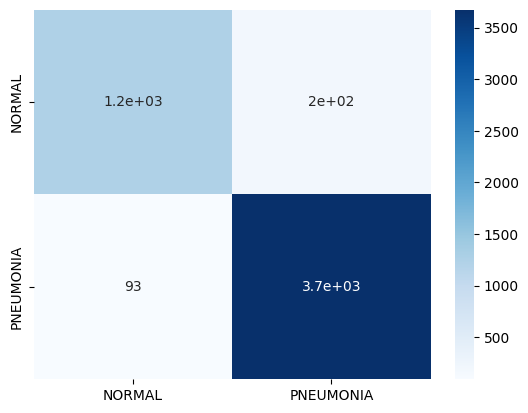

In [35]:
sns.heatmap(cmObject, annot = True, cmap="Blues")

In [37]:
m.save("classifier_pneumonia_224x224.h5")